# Introduction to Synthetic Population Generation

In [2]:
from pathlib import Path

import pandas as pd

from caveat.data.synth import ActivityGen
from caveat.data.utils import generate_population_conditional, trace_to_pam
from caveat.describe.times import (
    joint_time_distributions_plot,
    times_distributions_plot,
)
from caveat.describe.transitions import sequence_prob_plot

In [3]:
write_path = Path("tmp/synthetic_population.csv")
n = 10000

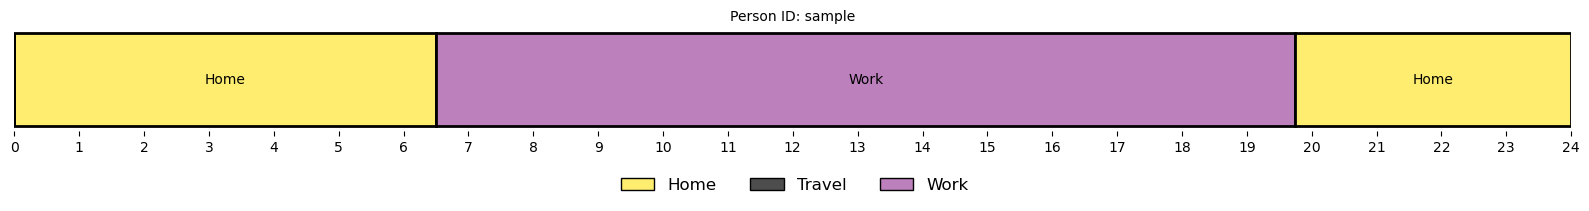

In [4]:
# FT worker generator
ftw = ActivityGen()
config = ftw.transition_config.copy()
for _, kv in config.items():
    for k, v in kv.items():
        if k in ["work"]:
            for i, (a, b) in enumerate(v):
                v[i] = (a, b * 10)
        if k in ["education", "shop", "leisure"]:
            for i, (a, b) in enumerate(v):
                v[i] = (a, b / 10)
ftw.build(config)

trace = ftw.run()
plan = trace_to_pam(trace, ftw.map)
plan.plot()

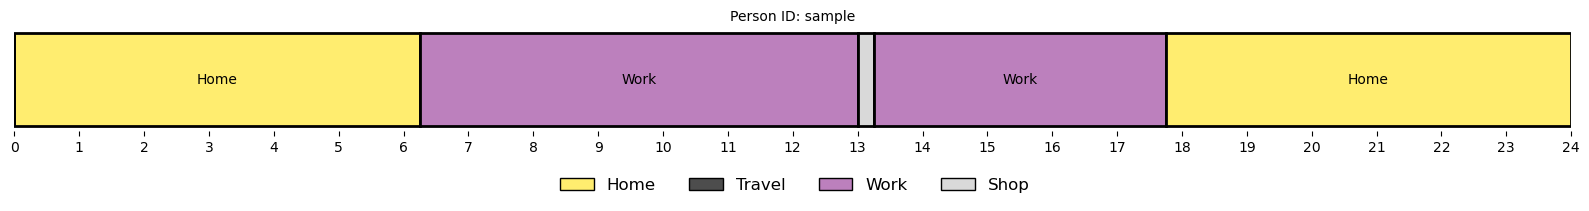

In [5]:
# PT worker generator
ptw = ActivityGen()
config = ptw.transition_config.copy()
for o, kv in config.items():
    for k, v in kv.items():
        if not o == "work":
            continue
        if k == "work":
            for i, (a, b) in enumerate(v):
                v[i] = (a, b / 100)
        if k in ["shop", "leisure"]:
            for i, (a, b) in enumerate(v):
                v[i] = (a, b * 100)
ptw.build(config)

trace = ptw.run()
plan = trace_to_pam(trace, ptw.map)
plan.plot()

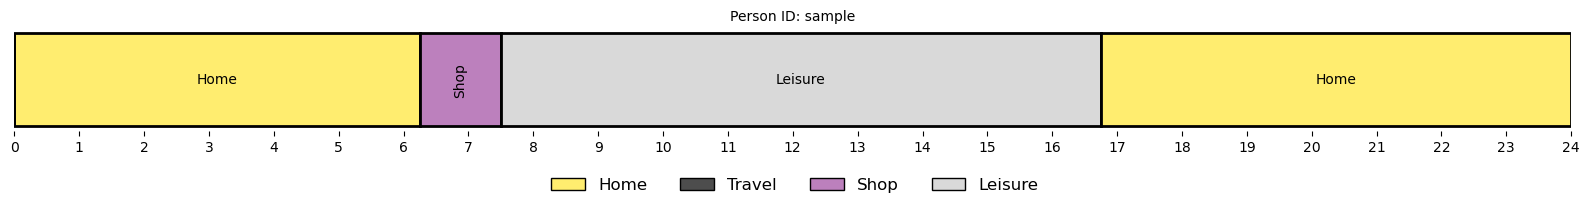

In [6]:
# Leisure generator
neet = ActivityGen()
config = neet.transition_config.copy()
for _, kv in config.items():
    for k, v in kv.items():
        if k in ["work", "education"]:
            for i, (a, b) in enumerate(v):
                v[i] = (a, 0)
        if k in ["shop", "leisure"]:
            for i, (a, b) in enumerate(v):
                v[i] = (a, b * 10)

neet.build(config)

trace = neet.run()
plan = trace_to_pam(trace, neet.map)
plan.plot()

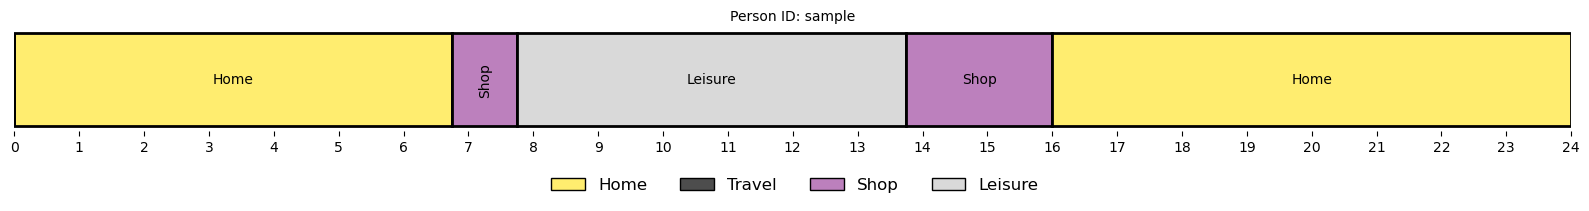

In [7]:
# FTE generator
fte = ActivityGen()
config = fte.transition_config.copy()
for _, kv in config.items():
    for k, v in kv.items():
        if k == "work":
            for i, (a, b) in enumerate(v):
                v[i] = (a, 0)
        if k == "education":
            for i, (a, b) in enumerate(v):
                v[i] = (a, b * 100)

fte.build(config)

trace = fte.run()
plan = trace_to_pam(trace, fte.map)
plan.plot()

In [8]:
population = generate_population_conditional(gens=(ftw, ptw, neet, fte), size=n)
population.act = population.act.map(ftw.map)
population = population[
    ["pid", "act", "start", "end", "duration", "gender", "age", "employment"]
]
population

,pid,act,start,end,duration,gender,age,employment
0,0,home,0,420,420,M,7,FTE
1,0,shop,420,450,30,M,7,FTE
2,0,leisure,450,615,165,M,7,FTE
3,0,shop,615,930,315,M,7,FTE
4,0,home,930,1440,510,M,7,FTE
...,...,...,...,...,...,...,...,...
43756,9998,work,375,1050,675,M,31,FTW
43757,9998,home,1050,1440,390,M,31,FTW
43758,9999,home,0,375,375,M,54,FTW
43759,9999,work,375,1140,765,M,54,FTW


In [9]:
write_path.parent.mkdir(exist_ok=True)
population.to_csv(write_path, index=False)

<Axes: xlabel='age', ylabel='duration'>

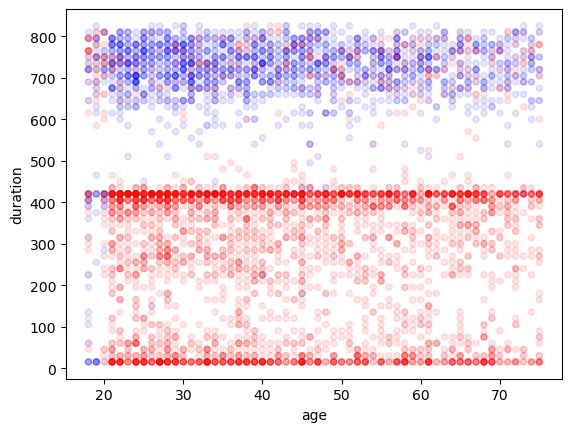

In [13]:
workers = population[population.act == "work"]
cs = workers.gender.map({"M": "blue", "F": "red"})
workers.plot(kind="scatter", x="age", y="duration", alpha=0.1, c=cs)

In [ ]:
def describe_col(population, col: str) -> pd.DataFrame:
    description = population.groupby("act")[col].describe()[
        ["count", "mean", "std", "min", "max"]
    ]
    description["attribute"] = col
    return description


def describe_cols(population, cols: list[str]) -> pd.DataFrame:
    description = pd.concat(
        [describe_col(population, c) for c in cols], ignore_index=False
    )
    description = description.reset_index().set_index(["attribute", "act"])
    return description


describe_cols(population, ["start", "end", "duration"]).round()

count    mean    std    min     max
attribute act                                             
start     education    358.0   941.0  116.0  735.0  1185.0
          home       20936.0   492.0  485.0    0.0  1365.0
          leisure     7688.0   520.0  177.0  375.0  1305.0
          shop        8486.0   516.0  190.0  375.0  1185.0
          work        3434.0   395.0   94.0  375.0  1260.0
end       education    358.0  1031.0   65.0  750.0  1200.0
          home       20936.0   908.0  517.0  375.0  1440.0
          leisure     7688.0   865.0  200.0  390.0  1365.0
          shop        8486.0   615.0  201.0  390.0  1200.0
          work        3434.0  1027.0  113.0  735.0  1275.0
duration  education    358.0    90.0   60.0   15.0   225.0
          home       20936.0   416.0  108.0   15.0   915.0
          leisure     7688.0   345.0  192.0   15.0   660.0
          shop        8486.0    99.0   75.0   15.0   495.0
          work        3434.0   633.0  127.0   15.0   825.0

In [ ]:
def time_distributions(population: pd.DataFrame, mapping: dict):
    starts = {k: [] for k in mapping.values()}
    ends = {k: [] for k in mapping.values()}
    durations = {k: [] for k in mapping.values()}
    for act, acts in population.groupby("act"):
        starts[act] = list(acts.start)
        ends[act] = list(acts.end)
        durations[act] = list(acts.duration)
    return starts, ends, durations

In [ ]:
starts, ends, durations = time_distributions(population, ftw.map)

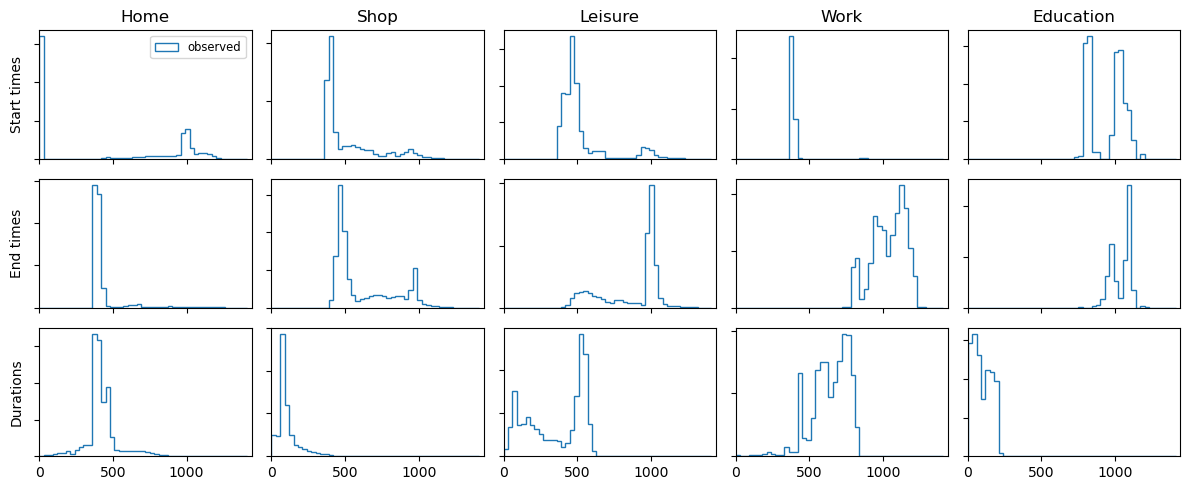

In [ ]:
_ = times_distributions_plot(population, ys={})

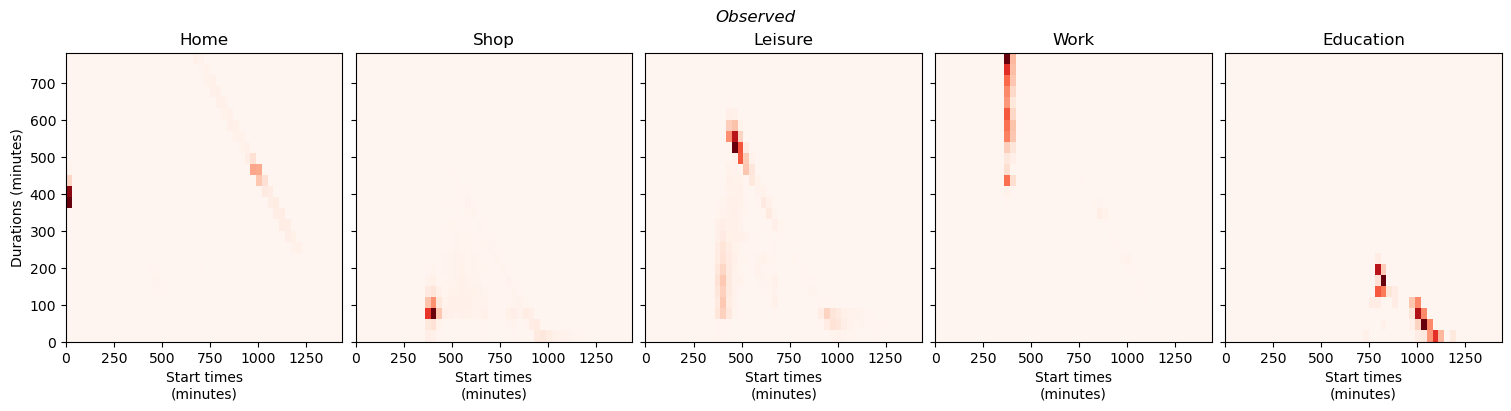

In [ ]:
_ = joint_time_distributions_plot(population, ys={})

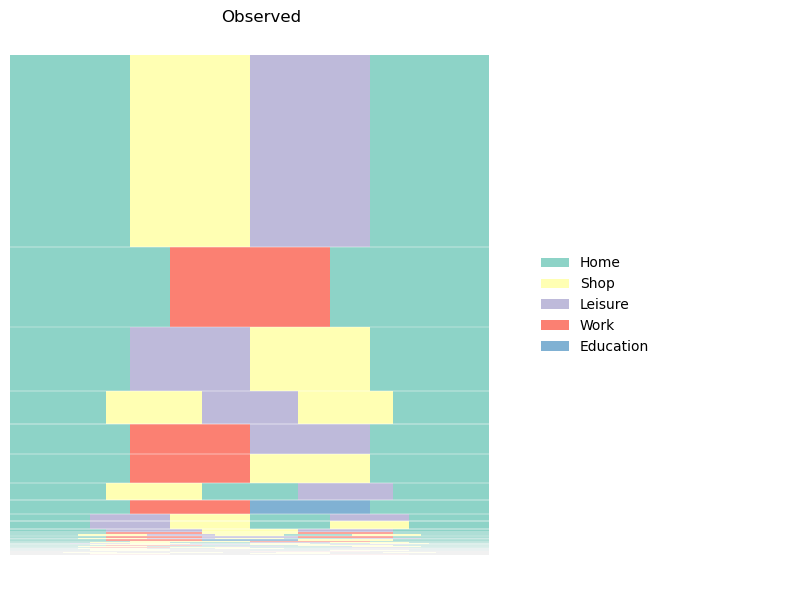

In [ ]:
_ = sequence_prob_plot(population, ys={}, figsize=(8, 6))